# Selection and Clustering of Stocks

As mentioned in the introduction we have used the Nifty50 Stocks as the initial bag of stocks to be analysed. 
Further more we use the K-Means Clustering algorithim on the daily returns of the stocks to group the 50 stocks and then select the stock with the best historical returns in each group as the member of our portfolio

### Importing Dependencies and Packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import plotly.graph_objects as go
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [2]:
import yfinance as yf

In [5]:
from datetime import date

### Download and format the Nifty50 Stock data into a Python DataFrame

Here we create a list of all the stock tickers of the Nifty50 stocks and use a python package called yfinance to download the daily price information directly using Yahoo Finance API's. 

We have also edited all the tickers and suffixed them with '.NS' to help Yahoo Finance understand that this information needs to be from the NSE - National Stock Exchange of India

In [3]:
companies_list = ['ASIANPAINT','GRASIM','SBILIFE','SBIN','BPCL','TCS','JSWSTEEL','M&M','BAJAJFINSV','HDFCLIFE',
                  'ICICIBANK','IOC','ONGC','ITC','HEROMOTOCO','NTPC','BAJAJ-AUTO','TATASTEEL','SUNPHARMA','RELIANCE',
                  'BRITANNIA','ULTRACEMCO','BAJFINANCE','SHREECEM','MARUTI','TATAMOTORS','CIPLA','HDFCBANK','DRREDDY',
                  'INDUSINDBK','ADANIPORTS','HINDUNILVR','HINDALCO','NESTLEIND','INFY','POWERGRID','LT','TECHM',
                  'BHARTIARTL','HCLTECH','EICHERMOT','WIPRO','UPL','COALINDIA','AXISBANK','KOTAKBANK','TATACONSUM',
                  'HDFC','TITAN','DIVISLAB']

In [4]:
companies_list_suffix = [sub + '.NS' for sub in companies_list]

In [6]:
today = date.today()

We have used the timeframe as 10 financial years i.e. from April 2012 to March 2022.

In [7]:
data_source = yf.download(tickers=companies_list_suffix,start='2012-04-01',end='2022-03-31')

[*********************100%***********************]  50 of 50 completed


In [53]:
data_source.to_pickle('Ten_year_data_consolidated.pkl')

In [8]:
data_source.head()

Adj Close                                          \
           ADANIPORTS.NS ASIANPAINT.NS AXISBANK.NS BAJAJ-AUTO.NS   
Date                                                               
2012-04-02    122.980980    301.884827  215.677551   1278.026245   
2012-04-03    122.885979    310.487885  219.599609   1272.003540   
2012-04-04    125.022713    307.444336  217.890701   1261.232544   
2012-04-09    127.017014    303.332489  214.024658   1274.590210   
2012-04-10    125.307632    301.251160  215.444077   1272.119629   

                                                                              \
           BAJAJFINSV.NS BAJFINANCE.NS BHARTIARTL.NS    BPCL.NS BRITANNIA.NS   
Date                                                                           
2012-04-02    618.439026     77.262932    296.566498  68.059387   260.206573   
2012-04-03    646.397400     79.984306    293.516327  69.891212   261.965363   
2012-04-04    685.636414     81.016396    287.677338  69.227783   260.888153   
2012-04-09    689.769409     80.118523    287.372345  67.381134   261.459717   
2012-04-10    692.346436     80.345306    287.459503  66.093887   259.437134   

                        ...       Volume                              \
              CIPLA.NS  ... SUNPHARMA.NS TATACONSUM.NS TATAMOTORS.NS   
Date                    ...                                            
2012-04-02  295.822540  ...      1217922       1384543       8010959   
2012-04-03  298.119110  ...       851142       3673526       8305886   
2012-04-04  292.473480  ...       627652       1432817       4834356   
2012-04-09  297.210083  ...       561580       1352343       3980653   
2012-04-10  297.592865  ...       752576       1505824       8246056   

                                                                           \
           TATASTEEL.NS   TCS.NS TECHM.NS TITAN.NS ULTRACEMCO.NS   UPL.NS   
Date                                                                        
2012-04-02      3440591  2326988   461116  5694452        115429  6884691   
2012-04-03      4407545  2269154   296716  3093349         56384  2717944   
2012-04-04      3277703  2165054   458500  3753999        123861   777297   
2012-04-09      2812366  1576628   266792  1948251        219494  2302327   
2012-04-10      4585830  1532992   355940  1877868        163962   640923   

                     
           WIPRO.NS  
Date                 
2012-04-02  3314604  
2012-04-03  2038002  
2012-04-04  2802268  
2012-04-09  1625514  
2012-04-10  3555497  

[5 rows x 300 columns]

In [9]:
data_source.isna().sum()

Adj Close  ADANIPORTS.NS    0
           ASIANPAINT.NS    0
           AXISBANK.NS      0
           BAJAJ-AUTO.NS    0
           BAJAJFINSV.NS    0
                           ..
Volume     TECHM.NS         0
           TITAN.NS         0
           ULTRACEMCO.NS    0
           UPL.NS           0
           WIPRO.NS         0
Length: 300, dtype: int64

In [10]:
stock_open = np.array(data_source['Open']).T # stock_open is numpy array of transpose of df['Open']
stock_close = np.array(data_source['Close']).T # stock_close is numpy array of transpose of df['Close']

In [11]:
#‘movement’ is the difference of opening and closing prices of a particular day. 
#Positive movement suggests to go long on stock(buy) and negative movement suggests to short the stock(sell).
movements = stock_close - stock_open

In [12]:
sum_of_movement = stock_close - stock_open

In [19]:
df = (data_source['Close'])
df = df.reset_index()
df.drop(['Date'], axis = 1, inplace= True)
df = df.set_axis(companies_list, axis=1, inplace=False)
daily_returns = df.pct_change()
annual_mean_returns = daily_returns.mean()*249
annual_mean_var = daily_returns.var()*249

df2 = pd.DataFrame(df.columns, columns = ['Stocks'])
df2['Variances'] = annual_mean_var.values
df2['Returns'] = annual_mean_returns.values
X= df2[['Returns', 'Variances']].values

### K-Means Clustering for Stock Market Data
K-means clustering is a type of unsupervised learning model. Unsupervised models are used to learn from a data set that is not labeled or classified. It identifies commonalities in the data set and react based on the presence or absence of such commonalities in each data point.

A K-means clustering model simply initialize K number of centroids and data points that are close (similar) to the centroids will be categorized as a cluster.

We then go on to use the elbow method to decide totaly number of clusters required. 

* Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
* Inertia: It is the sum of squared distances of samples to their closest cluster center.

We iterate the values of k from 2 to 15 and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range.

We then visualize number of clusters vs intertia or distortion, the optimal cluster is where the graph takes a sharp turn and starts flattening or is commonly known as the 'Elbow'.

In [39]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 15)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k).fit(X)
	kmeanModel.fit(X)

	distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
										'euclidean'), axis=1)) / X.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
								'euclidean'), axis=1)) / X.shape[0]
	mapping2[k] = kmeanModel.inertia_


In [40]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

2 : 0.0535927633785085
3 : 0.04720159093116926
4 : 0.038374271164780746
5 : 0.03320077129704445
6 : 0.028807273145111886
7 : 0.02478506952564111
8 : 0.023200941335407718
9 : 0.02070712568328613
10 : 0.018962907736475902
11 : 0.018127497893920312
12 : 0.0164914272663068
13 : 0.015458559835011952
14 : 0.014246424267504427


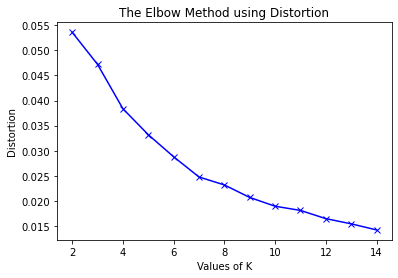

In [41]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

2 : 0.22804026931574217
3 : 0.1492839519881375
4 : 0.0910392878436015
5 : 0.06957379583677971
6 : 0.052102425752998956
7 : 0.044364752185650905
8 : 0.03507273130604134
9 : 0.0289763158527755
10 : 0.02305358038470752
11 : 0.020880208466327953
12 : 0.01721816099824955
13 : 0.014731358648502849
14 : 0.012921731192024671


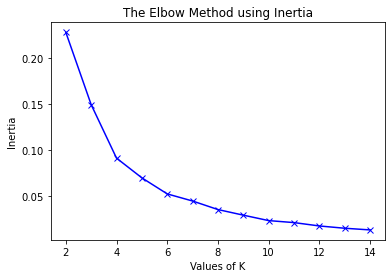

In [42]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

After the 6th cluster we see that the difference in values start to reduce and the curve is flattening. Therefore, we select 6 clusters.

An important point to note here is we do not remove outliers which is a common practice in K-means clustering. This is mainly because our aim is to find unique stocks and an outlier by definition is unique.

In [43]:
kmeans = KMeans(n_clusters=6).fit(X)
labels = kmeans.labels_
labels

array([1, 1, 5, 0, 2, 2, 0, 5, 1, 0, 3, 1, 0, 1, 4, 1, 0, 4, 0, 3, 5, 4,
       4, 5, 4, 0, 3, 1, 4, 0, 0, 4, 0, 3, 3, 0, 4, 0, 0, 1, 0, 1, 5, 5,
       4, 1, 1, 4, 1, 0], dtype=int32)

In [44]:
df2['Cluster_labels'] = labels

,Stocks,Variances,Returns,Cluster_labels
0,TCS,0.140324,0.525274,1
1,BPCL,0.116937,0.394055,1
2,ITC,0.109606,0.304364,5
3,IOC,0.096548,0.298971,0
4,HDFCBANK,0.131764,0.298114,2
5,TATACONSUM,0.110019,0.291625,2
6,TITAN,0.135808,0.287754,0
7,BAJAJFINSV,0.069076,0.273546,5
8,NTPC,0.077739,0.264510,1
9,GRASIM,0.069488,0.261900,0


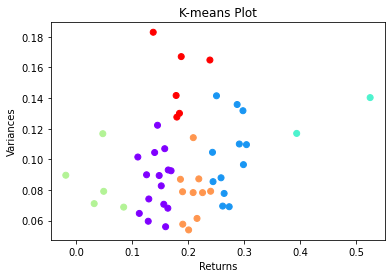

In [45]:
#plot the clusters
plt.scatter(X[:,0],X[:,1], c= labels, cmap='rainbow')
plt.title('K-means Plot')
plt.xlabel('Returns')
plt.ylabel('Variances')
plt.show()

### Creating our Portfolio

We now have a dataframe with the 

1. Stocks
2. Average Returns
3. Average Variances
4. The clusters they belong to

Then we go ahead and sort the data by highest to lowest returns. 
A function is then built to select the first stock i.e. the stock with the highest return in each cluster.
Thereby completing the selection of stocks for our portfolio.


In [46]:
df2.sort_values(by=['Returns'], inplace=True, ascending=False)
df2 = df2.reset_index(drop=True)

In [68]:
#building a function for a simple portfolio
def diverse_port():
    for i in range(0,6):
        symbol = df2[df2['Cluster_labels'] == i].head(1)
        print(symbol[['Stocks', 'Cluster_labels']])
        

In [69]:
diverse_port()

  Stocks  Cluster_labels
3    IOC               0
  Stocks  Cluster_labels
0    TCS               1
     Stocks  Cluster_labels
4  HDFCBANK               2
       Stocks  Cluster_labels
10  KOTAKBANK               3
   Stocks  Cluster_labels
14     LT               4
  Stocks  Cluster_labels
2    ITC               5


### Portfolio

Therefore our porfolio consists of:

1. IOC - Indian Oil Corporation Limited is an Indian government-owned oil and gas explorer and producer, headquartered in New Delhi. It is a public sector undertaking whose operations are overseen by the Ministry of Petroleum and Natural Gas. Indian Oil is ranked 212th on the Fortune Global 500 list of the world's biggest corporations as of 2021.
2. TCS - Tata Consultancy Services (TCS) is an Indian multinational information technology (IT) services and consulting company with its headquarters in Mumbai. It is a part of the Tata Group and operates in 149 locations across 46 countries. It is the second largest Indian company by market capitalisation and is among the most valuable IT service brands worldwide.
3. HDFCBANK - HDFC Bank Limited is an Indian banking and financial services company headquartered in Mumbai. It is India's largest private sector bank by assets and world's 10th largest bank by market capitalisation as of April 2021. It is the third largest company by market capitalisation of USD 122.50 billion on the Indian stock exchanges. It is also the fifteenth largest employer in India with nearly 120,000 employees.
4. KOTAKBANK - Kotak Mahindra Bank Limited is an Indian banking and financial services company headquartered in Mumbai, India. It offers banking products and financial services for corporate and retail customers in the areas of personal finance, investment banking, life insurance, and wealth management. It is India's third largest private sector bank by assets and by market capitalisation as of November 2021.
5. LT - Larsen & Toubro Ltd, commonly known as L&T, is an Indian multinational conglomerate company, with business interests in engineering, construction, manufacturing, technology, information technology and financial services, headquartered in Mumbai. The company is counted among world's top five construction companies.
6. ITC - ITC Limited is an Indian conglomerate company headquartered in Kolkata.[5] ITC has a diversified presence across industries such as cigarettes, FMCG, hotels, software, packaging, paperboards, specialty papers and agribusiness. The company has 13 businesses in 5 segments. It exports its products in 90 countries. Its products are available in 6 million retail outlets.